# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
#from nb_new_data_augmentation import *

In [5]:
import pdb

In [6]:
__version__

'1.0.55'

# 6D image test

In [7]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [8]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [9]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [10]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [11]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset parameters full dataset

In [12]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [13]:
df_train.tail()

,path,experiment,sirna,multi,valid
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,1
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,1
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,1
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,1
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,1


In [14]:
df_test.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s2,U2OS-05
19893,U2OS-05/Plate4/O20_s2,U2OS-05
19894,U2OS-05/Plate4/O21_s2,U2OS-05
19895,U2OS-05/Plate4/O22_s2,U2OS-05
19896,U2OS-05/Plate4/O23_s2,U2OS-05


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [15]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [16]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [17]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [56]:
## ResNet50pt
#sz, bs = 96, 8*46 # 77560MiB /  7952MiB

## XResNet50c
#sz, bs = 96, 8*46 # 7573MiB /  7952MiB
#sz, bs = 128, 8*52 # 7935MiB /  7952MiB
#sz, bs = 256, 8*13 # 7929MiB /  7952MiB
#sz, bs = 512, 8*3 # 7575MiB /  7952MiB

## XResNet50c AdaCos
#sz, bs = 128, 8*50 # 7846MiB /  7952MiB

## XResNet152fh
#sz, bs = 128, 8*23 # 7919MiB /  7952MiB

## SE_XResNet152fh
#sz, bs = 128, 8*18 # 7752MiB /  7952MiB
#sz, bs = 256, 8*4 # 7639MiB /  7952MiB
#sz, bs = 512, 8 #


## AdaCos-SE-XResNet50c FP32
#sz, bs = 128, 8 # TEST
#sz, bs = 128, 8*20 # 7430MiB /  7952MiB --> FP32 !!!
sz, bs = 256, 8*5 # 7475MiB /  7952MiB
#sz, bs = 512, 8 #
# === preds ===
#sz, bs = 256, 8*25 # 5391MiB /  7952MiB
#sz, bs = 256, 8*40 # 7741MiB /  7952MiB
#sz, bs = 512, 8*5 # 6051MiB /  7952MiB

In [57]:
sz, bs

(256, 40)

In [58]:
# normal tfms
#tfms = get_transforms()

# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=color_augmentation())

# extended tfms + CutOut
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), cutout(n_holes=(0,20))])

### Dataset setup

In [59]:
# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [18]:
# FULL DATASET (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_none() # !!!
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [35]:
# VALID SPLIT PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) 
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz) # !!!
        .databunch(bs=bs))

In [21]:
# FULL DATASET PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_none() # !!!
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz)
        .databunch(bs=bs))

In [22]:
data

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [23]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [24]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [25]:
#data.classes

In [26]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

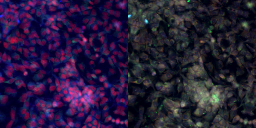

In [27]:
data.train_ds[0][0]

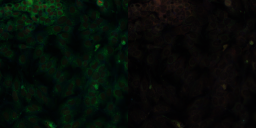

In [28]:
data.test_ds[0][0]

### Adversarial full dataset

In [32]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [282]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [283]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [284]:
data_a.batch_size

208

In [285]:
data_a.train_ds[0]

(Image6D (6, 128, 128), MultiCategory HEPG2-01;513)

In [286]:
#data_a.classes

In [287]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [288]:
data_a.train_ds[0][1].data.sum()

2.0

In [289]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [290]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

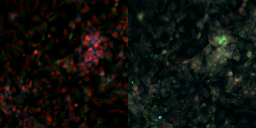

In [291]:
data_a.train_ds[0][0]

In [292]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## SE-XResNet50Feature+AdaCos-Head

SE-XResNet152Feature model including AdaptiveConcatPool2d stage + normal fastai head

In [23]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [24]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [25]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [26]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [27]:
#se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)
se_xresnet50f = SE_XResNetFeature(4, [3,4,6 ,3], c_in=6) #, c_out=1108)

In [28]:
#se_xresnet152f

In [29]:
se_xresnet50f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 2048, 4, 4])

In [30]:
#se_xresnet50f(data.train_ds[0][0].data.unsqueeze(0)).shape

### AdaCos-Head

In [31]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    #nc:int, 
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    lin_ftrs = [nf, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [32]:
adacos_head = create_adacos_head(nf=4*512*2)#, nc=1108)

In [33]:
#adacos_head

In [34]:
#adacos_head(torch.randn(2, 2048, 4, 4)).shape

In [35]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        #if yb is None:
        #    return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #one_hot.scatter_(1, torch.tensor(yb).view(-1,1).long(), 1)
        one_hot.scatter_(1, yb.view(-1,1).long(), 1)
        
        with torch.no_grad():
            B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
            B_avg = torch.sum(B_avg) / xb.size(0)
            #print(B_avg)
            theta_med = torch.median(theta[one_hot == 1])
            self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
            #print(self.s)
        output = self.s * logits

        return output

In [36]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body, head):
        super(AdaCosNet, self).__init__()
        self.body = body
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb):
        features = self.body(xb)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [37]:
adacos_se_xresnet50c = AdaCosNet(se_xresnet50f, adacos_head)

In [38]:
adacos_se_xresnet50c(torch.randn(2,6,sz,sz), torch.tensor([513, 1])).shape

torch.Size([2, 1108])

In [39]:
#xb, yb = next(iter(data.train_dl))

In [40]:
#xb.shape, yb.shape

In [41]:
#adacos_se_xresnet50c.cuda();

In [42]:
#adacos_se_xresnet50c(xb,yb).shape

In [43]:
#adacos_se_xresnet50c(xb,yb)

In [44]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [45]:
#@dataclass
#class AppendBatchTargs(LearnerCallback):
#    def __init__(self, learn:Learner):
#        super().__init__()
#    def on_batch_begin(self, last_input, last_target, **kwargs):
#        return {'last_input':(last_input, last_target), 'last_target':last_target}

# Training

## adacos_se_xresnet50c

In [60]:
learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy], callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()


In [46]:
#learn.opt_func

In [47]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func

### ADD CLIP PARAMETER TOO???

In [43]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### 128px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 6.31E-08


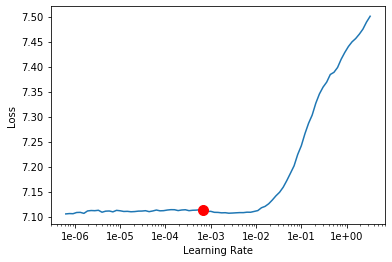

In [58]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.049819,7.016726,0.001680,06:25
1,6.863423,6.911915,0.002908,06:18
2,6.668958,6.765998,0.005234,06:20
3,6.532576,6.739511,0.005492,06:21


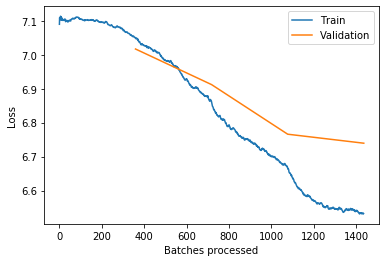

In [53]:
learn.recorder.plot_losses()

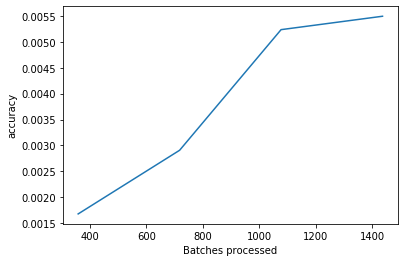

In [54]:
learn.recorder.plot_metrics()

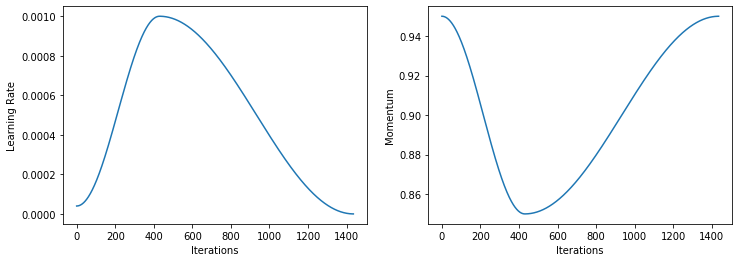

In [55]:
learn.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05
Min loss divided by 10: 1.74E-06


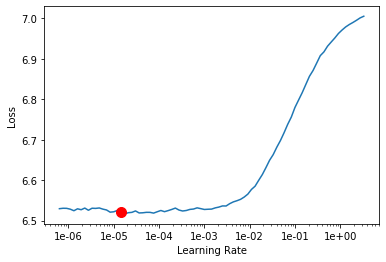

In [56]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [57]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.514760,6.737056,0.006397,06:14
1,6.506877,6.700912,0.006526,06:18
2,6.339585,6.594904,0.008723,06:19
3,6.127261,6.351635,0.015379,06:20
4,5.902542,6.137679,0.021776,06:16
5,5.717720,6.077800,0.022293,06:20
6,5.559706,5.969693,0.026557,06:18
7,5.481439,5.964508,0.026686,06:20


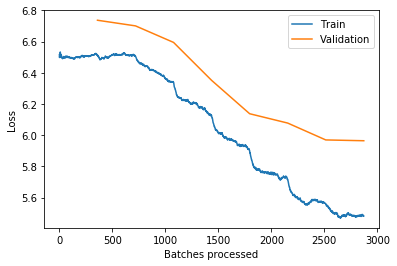

In [58]:
learn.recorder.plot_losses()

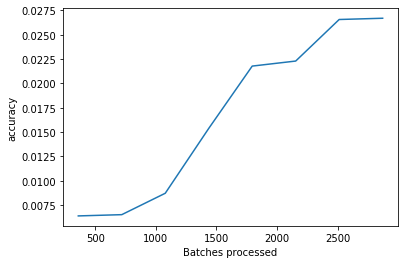

In [59]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 1.45E-06


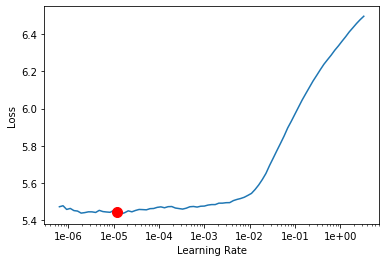

In [60]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [61]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.510902,6.051723,0.023262,06:15
1,5.645646,6.273204,0.018093,06:19
2,5.582894,6.051350,0.025330,06:20
3,5.387306,5.912311,0.035733,06:19
4,5.179842,5.641308,0.046071,06:19
5,4.996719,5.510844,0.054988,06:20
6,4.872578,5.425763,0.061708,06:17
7,4.789527,5.408553,0.062807,06:17


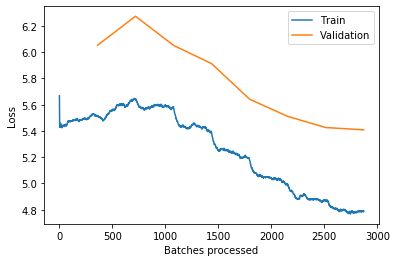

In [62]:
learn.recorder.plot_losses()

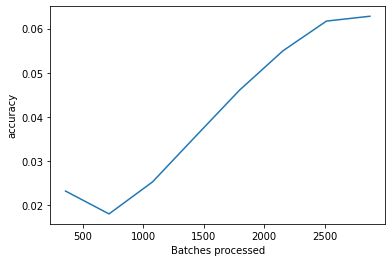

In [63]:
learn.recorder.plot_metrics()

In [68]:
#learn.recorder.plot_lr()

In [69]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e020_20190727')

In [47]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e020_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


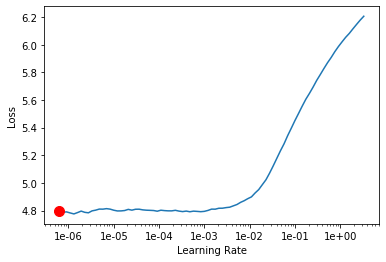

In [48]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.771175,5.423917,0.062484,06:16
1,4.817340,5.438628,0.062548,06:18
2,4.898350,5.408331,0.060675,06:17
3,4.922478,5.454489,0.059188,06:20
4,4.932737,5.767035,0.048139,06:16
5,4.901583,5.714163,0.051434,06:22
6,4.788288,5.359027,0.071207,06:19
7,4.702081,5.302422,0.070496,06:17
8,4.619848,5.322471,0.076699,06:20
9,4.496301,5.413292,0.068752,06:14


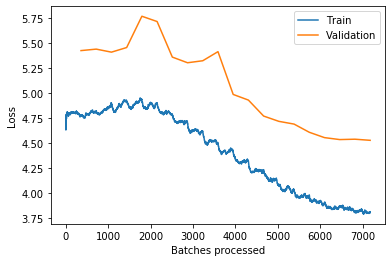

In [50]:
learn.recorder.plot_losses()

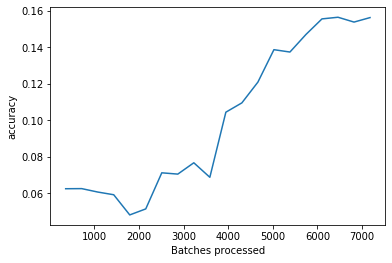

In [51]:
learn.recorder.plot_metrics()

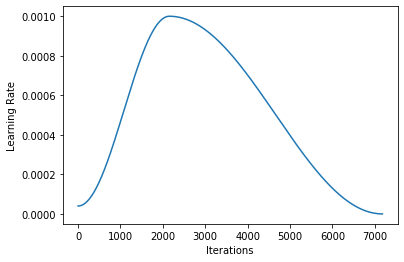

In [52]:
learn.recorder.plot_lr()

In [53]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040_20190727')

In [61]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### 128px over day NOT USED!

In [ ]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=5)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet50/adacos_se_xresnet50c_val-split-v2_128px_e040-080_20190727_best')


In [ ]:
learn.fit(40, lr=1e-4, callbacks=[savem, redlr])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
# Best model save as ??? !

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e080_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128px_e080_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### 256px Standard training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.74E-04


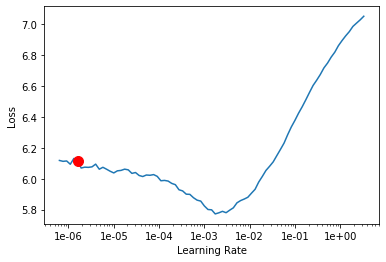

In [62]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [63]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.338190,4.678701,0.141574,11:30
1,4.159822,4.521640,0.163479,11:27
2,4.004293,4.464844,0.171750,11:31
3,4.003797,4.450500,0.174076,11:32


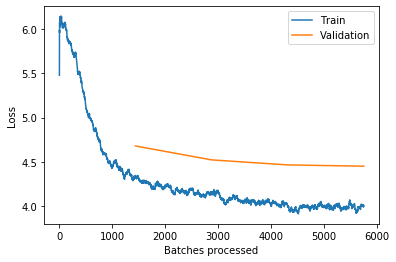

In [64]:
learn.recorder.plot_losses()

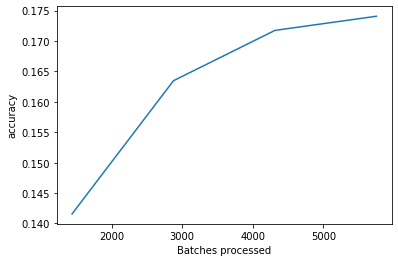

In [65]:
learn.recorder.plot_metrics()

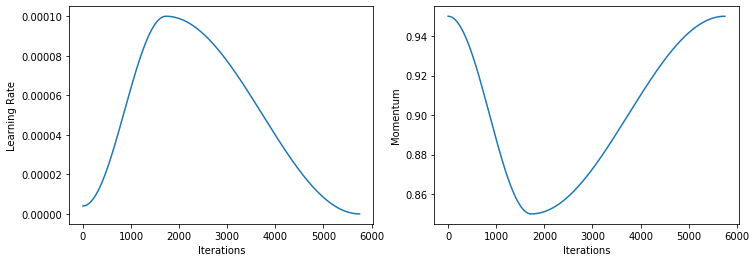

In [66]:
learn.recorder.plot_lr(show_moms=True)

In [67]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e004_20190727')

In [68]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e004_20190727');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-07


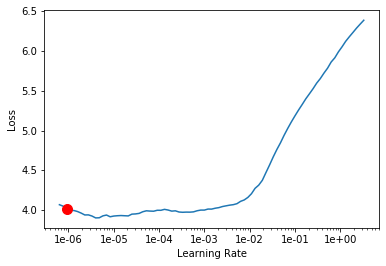

In [69]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e012_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e012_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(8, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e020_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e020_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-4)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### 256px over day

In [ ]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss', patience=5)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e040-XYZ_20190727_best')


In [ ]:
learn.fit(50, lr=1e-3, callbacks=[savem, redlr])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
# Best model save as "adacos_se_xresnet50c_val-split-ex-v1_128px_e040-143_20190723_best"!

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256eXYZ_20190727')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256eXYZ_20190727');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

#### CutOut???

### 256px Blend CutMix

In [ ]:
class BlendCallback(LearnerCallback):
    "Callback that creates the blend input and target."
    def __init__(self, learn:Learner,
                 size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0.,
                 blend_type:str='cut', grid:bool=True,
                 same_size:bool=True, same_crop:bool=True, same_image:bool=False):
        ''' Modifies one or multiple subregions of an image
        Parameters:
        size:
            int tuple(height pixels, wide pixels), float tuple (height % img, wide % img)
            int (pixels) or float (percent_tuple)
            None full image
        alpha: proba that each patch is modified from np.random.beta(alpha, alpha)
        fixed_proba: proba that each individual patch is modified. If >0 overrides alpha.
        blend_type: 'zero', 'noise', 'mix', 'cut' or 'rand'(any of the previous)
        grid: True - a grid is applied to the image so that patches never overlap (required in 'mix' and 'cut')
        same_size: True - all patches will have approx the same size, otherwise random
        same_crop: cropping subregion will be the same as input subregion, otherwise different
        same_image: False - cropping image will be different from input image, otherwise same
        '''
        assert blend_type in ['zero', 'noise', 'mix', 'cut', 'random'], \
        print("make sure you select one of these blend_types: 'zero', 'noise', 'mix', 'cut', 'random'")
        if not grid and not same_image:
            assert blend_type in ['zero', 'noise'],\
            print('either grid or same_image must be set to True when using', blend_type)
        super().__init__(learn)
        self.size,self.alpha,self.fixed_proba,self.blend_type = size,alpha,fixed_proba,blend_type
        self.grid,self.same_size,self.same_crop,self.same_image = grid,same_size,same_crop,same_image

    def on_train_begin(self, **kwargs):
        if not self.same_image: self.learn.loss_func = BlendLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies blend to `last_input` and `last_target` if `train`."
        if not train: return {'last_input': last_input, 'last_target': last_target}
        if self.alpha == 0 and self.fixed_proba == 0:
            return {'last_input': last_input, 'last_target': last_target}

        x_size = last_input[0].size()
        bs = x_size[0] # batch size
        i_h, i_w = x_size[2:] # image height, width
        if not isinstance(self.size, tuple): self.size = (self.size, self.size)
        p_h, p_w = self.size # patch percent height, width
        if p_h == 1 or isinstance(p_h, float): h = int(p_h * i_h) # patch height in pixels
        else: h = p_h
        if p_w == 1 or isinstance(p_w, float): w = int(p_w * i_w) # patch width in pixels
        else: w = p_w
        if w == 0 or h == 0: return {'last_input': last_input, 'last_target': last_target}
        patched_images = last_input[0].clone()

        # patches that will be modified
        n_patches = (i_h // h, i_w // w)
        patch_len = n_patches[0] * n_patches[1]
        patches = get_x1_coords(x_size, n_patches, same_size=self.same_size)
        if self.fixed_proba != 0:
            lambd = self.fixed_proba
        else:
            lambd = np.random.beta(self.alpha, self.alpha)
            lambd = max(lambd, 1- lambd)
        if patch_len == 1: patch_ids = [0]
        elif self.fixed_proba != 0:
            patch_ids = np.arange(patch_len)[np.random.rand(patch_len) <= lambd]
        else:
            patch_ids = np.random.choice(np.arange(patch_len), int(patch_len * (1 - lambd)), replace=False)
        n_mod_patches = len(patch_ids)
        if n_mod_patches == 0: return {'last_input': last_input, 'last_target': last_target}
        #mod_patches = [patches[i] for i in patch_ids]
        c_ = torch.zeros((bs, n_mod_patches)).float().to(last_input.device) # patch labels
        W_ = torch.zeros(n_mod_patches).float().to(last_input.device) # new weights
        idx = torch.linspace(0, bs - 1, steps=bs).to(dtype=torch.int64, device=last_input.device)
        if self.blend_type.lower() == 'random': _blend = np.random.choice(['zero', 'noise', 'mix', 'cut'])
        else: _blend = self.blend_type.lower()
        for i,j in enumerate(patch_ids):
            #x1 coordinates
            if self.grid: bby1, bby2, bbx1, bbx2 = patches[j]
            else: bby1, bby2, bbx1, bbx2 = get_x1_rand_coords(x_size, n_patches, w, h,
                                                              same_size=self.same_size)
            # Blend
            if _blend == 'zero': patched_images[..., bby1:bby2, bbx1:bbx2] = 0
            if _blend == 'noise':
                noise = last_input.new(np.random.rand(bby2 - bby1, bbx2 - bbx1))
                patched_images[..., bby1:bby2, bbx1:bbx2] = noise
            else:
                if not self.same_image: idx = torch.randperm(bs).to(last_input.device)
                #x2 coordinates
                if self.same_crop:
                    x2 = last_input[idx][..., bby1:bby2, bbx1:bbx2]
                else:
                    ccy1, ccy2, ccx1, ccx2 = get_x2_coords(x_size, bby1, bby2, bbx1, bbx2)
                    x2 = last_input[idx][..., ccy1:ccy2, ccx1:ccx2]
                if _blend == 'mix':
                    x1 = last_input[..., bby1:bby2, bbx1:bbx2]
                    if self.size == (1, 1):
                        patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * lambd + x2 * (1 - lambd)
                    else: patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * .5 + x2 * .5
                if _blend == 'cut':
                    patched_images[..., bby1:bby2, bbx1:bbx2] = x2
            W_[i] = (bby2 - bby1) * (bbx2 - bbx1) / (i_w * i_h)
            c_[:, i] = last_target[idx].float()
        # modify last target
        if not self.same_image and n_mod_patches > 0:
            new_target = torch.cat((last_target[:,None].float(), c_, W_[None].repeat(bs, 1)), dim=1)
        else: new_target = last_target
        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if not self.same_image: self.learn.loss_func = self.learn.loss_func.get_old()


def blend(learn:Learner, size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0.,
                 blend_type:str='cut', grid:bool=True,
                 same_size:bool=True, same_crop:bool=True, same_image:bool=False) -> Learner:
    learn.callback_fns.append(partial(BlendCallback, size=size, alpha=alpha,
                                      fixed_proba=fixed_proba, blend_type=blend_type, grid=grid,
                                      same_size=same_size, same_crop=same_crop, same_image=same_image))
    return learn

setattr(blend, 'cb_fn', BlendCallback)
Learner.blend = blend

In [ ]:
class BlendLoss(nn.Module):
    "Adapt the loss function `crit` to go with blend data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if target.ndim == 2:# and target.shape[-1] >1:
            n_mod_patches = (target.shape[-1] - 1) // 2
            c_ = target[:, 1:n_mod_patches + 1]
            W_ = target[:, n_mod_patches + 1:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(n_mod_patches)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

In [ ]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'blend_type': 'zero', 
}

In [ ]:
learn.blend(**kwargs);

In [ ]:
learn.fit_one_cycle(4, 1e-3)

In [ ]:
%debug

In [ ]:
# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

In [ ]:
learn.cutmix()

# Get features

In [45]:
learn = Learner(data, adacos_se_xresnet50c)

In [46]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-ex-v1_128e143_256e040CO020-102_20190726_best');

In [47]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = adacos_se_xresnet50c.body(xb)
                head_out = adacos_se_xresnet50c.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
    return feats, targs

## Train

In [48]:
feats, targs = get_feats(learn.model, learn.data.train_dl, cycles=3)

In [49]:
len(feats), len(targs)

(267, 267)

In [50]:
# total images: 89*320
learn.data.batch_size * len(learn.data.train_dl)

28480

In [51]:
len(learn.data.train_dl), len(learn.data.valid_dl), len(learn.data.test_dl)

(89, 25, 63)

In [52]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [53]:
feats.shape, targs.shape

(torch.Size([85440, 512]), torch.Size([85440]))

In [54]:
np.save('pred/feats_train.npy', feats)
np.save('pred/targs_train.npy', targs)

## Valid

In [ ]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [ ]:
len(feats), len(targs)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, targs.shape

In [ ]:
np.save('pred/feats_valid.npy', feats)
np.save('pred/targs_valid.npy', targs)

## Test

In [ ]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [ ]:
del targs

In [ ]:
len(feats)

In [ ]:
feats = torch.cat(feats, dim=0)

In [ ]:
feats.shape

In [ ]:
np.save('pred/feats_test.npy', feats)

# Submission

## AdaCos

In [101]:
# get the names
preds_names = learn.data.test_ds.x.items

In [80]:
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]
# including sX
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [81]:
len(preds_names)

19897

In [85]:
preds_test = np.load('pred/preds_test.npy')

In [86]:
preds_test

array([ 52,  69, 889, 148, ..., 316, 429, 271, 557])

In [87]:
len(preds_test)

19897

In [88]:
df_preds = pd.DataFrame({'id_code': preds_names, 'sirna': preds_test})

In [89]:
df_preds.head()

,id_code,sirna
0,HEPG2-08_1_B03,52
1,HEPG2-08_1_B04,69
2,HEPG2-08_1_B05,889
3,HEPG2-08_1_B06,148
4,HEPG2-08_1_B07,903


In [90]:
# 'adacos_se_xresnet50c_val-split-ex-v1_128e143_256e040CO020-102_20190726_best'
model = 'metriclearn_se_xresnet50c_val-split-ex-v1_128e143_256e040CO020-102_20190726_best_TTAf'

In [91]:
df_preds.to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [94]:
#!kaggle

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: the following arguments are required: command


In [97]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


100%|██████████████████████████████████████| 83.7k/83.7k [00:03<00:00, 24.4kB/s]
Successfully submitted to Recursion Cellular Image Classification

# Error analysis

In [ ]:
preds_correct = np.load('preds_valid_correct.npy')

In [ ]:
df_erros = pd.DataFrame({'id_code': preds_names, 'correct': preds_test})

In [ ]:
df_erros[df_errors['correct'] == False]

In [ ]:
# ERROR ANALYSIS !!!